In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set()
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split

In [43]:
#architecture

class Generator_net(nn.Module):
    def __init__(self, upscale_factor, num_blocks):
        super(Generator_net, self).__init__()

        
        self.conv1 = nn.Sequential(nn.Conv1d(3,64, kernel_size = 9, stride = 1, padding = 4),
                                        nn.PReLU())
        blocks = []
        for _ in range(num_blocks):
            blocks.append(SRResNet(64))

        self.blocks = nn.Sequential(*blocks)

        self.conv2 = nn.Sequential(nn.Conv1d(64,64, kernel_size = 3, stride = 1, padding = 1),
                                              nn.BatchNorm1d(64))
        self.conv3 = nn.Sequential(nn.Conv1d(128,64, kernel_size = 3, stride = 1, padding = 1),
                                              nn.BatchNorm1d(64),nn.PReLU())
        self.conv4 = nn.Sequential(nn.Conv1d(64,3 ,kernel_size = 9, stride = 1, padding = 4))
        dummy = math.log2(upscale_factor)
        k = int(dummy)
        
        dense_layer = []
        for _ in range(k):
            dense_layer += [
              nn.Conv1d(64, 128, 3, 1, 1),
              nn.BatchNorm1d(128),
              None,
              nn.PReLU(),

            ]

        self.dense_layer = nn.Sequential(*dense_layer)




    def pixelShuffle1D(self,input,r):
        #print("PS input shape: ", input.shape)
        batch_size, channel, length = input.shape
        channels_out = channel // r
        new_length = length * r
        input_view = input.view(batch_size, channels_out, r, length)
        output = input_view.permute(0, 1, 3, 2).contiguous()
        output = output.view(batch_size, channels_out, new_length)
        #print("PS output shape: ", output.shape)
        return output

    def forward(self, vec):
        x1 = self.conv1(vec)
        #print("After conv1 layer: ", x.shape)
        x = self.blocks(x1)
        #print("After block layer: ", x.shape)
        x2 = self.conv2(x)
        x = torch.add(x1,x2) #skip connection
        #print("After conv2 layer: ", x.shape)
        for i,layer in enumerate(self.dense_layer):
            if layer is None:
                x = self.pixelShuffle1D(x,r=2)  # Custom pixel shuffle operation
                #print(f"After dense layer {i}: ", x.shape)
            else:
                x = layer(x)
      
        output = self.conv4(x)
        #print("After conv3 layer: ", output.shape)
        return output



class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        in_filters = 3  # initial number of filters
        layers = []
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(self.discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            #print(out_filters)
            in_filters = out_filters

        layers.append(nn.Conv1d(out_filters, 1, kernel_size=3, stride=1, padding = 1))

        self.model = nn.Sequential(*layers)

    def discriminator_block(self, in_filters, out_filters, first_block=False):
        layers = []
        layers.append(nn.Conv1d(in_filters, out_filters, kernel_size=3, stride=1, padding = 1))
        if not first_block:
            layers.append(nn.BatchNorm1d(out_filters))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Conv1d(out_filters, out_filters, kernel_size=3))
        layers.append(nn.BatchNorm1d(out_filters))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, data):
        output = self.model(data)
        return output

      


class SRResNet(nn.Module):
  def __init__(self, feature_num):
    super(SRResNet, self).__init__()
    self.convolutional_block = nn.Sequential(
        nn.Conv1d(feature_num, feature_num, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(feature_num, 0.1),
        nn.PReLU(),
        nn.Conv1d(feature_num, feature_num, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm1d(feature_num, 0.1),
    )

  def forward(self,x):
      return self.convolutional_block(x) + x


In [44]:
#loss

def loss_function_mse(generated, real):
  mse_loss = nn.MSELoss()
  loss = mse_loss(generated, real)
  return loss

 
# def weighted_mse_loss(input, target, weights):
  
#     out = (input - target)**2
#     #print(out.shape) = torch.Size([20, 3, 800])
#     out = out * weights.expand_as(out) #same dimensionality
#     loss = out.mean() 
#     return loss

# def loss_function_mse(generated, real, start_weight=5, end_weight=1):
#     #print(generated.shape)
#     sequence_length = generated.size(2)
#     penalty_length = int(sequence_length * 0.25)
#     penalty = 5
#     normal_weight = 1
#     #print(sequence_length)
#     #weights = torch.linspace(start_weight, end_weight, steps=sequence_length)
#     first_weights = torch.full((penalty_length,), penalty)
#     rest_weights =  torch.full((sequence_length - penalty_length,), normal_weight)
    
#     weights = torch.cat((first_weights, rest_weights), dim=0)
    
#     if generated.is_cuda:
#         weights = weights.to(generated.device)
    
#     mse_loss = weighted_mse_loss(generated, real, weights)
#     return mse_loss
    

def loss_function_adv(output, target):
  loss = F.binary_cross_entropy_with_logits(output, target) # or nn.BCEWithLogitsLoss()
  return loss

def loss_L1(input,target):
    loss = nn.L1Loss()
    output = loss(input,target)
    return output

In [45]:
#low-resolution training data(temporal):

def downsample_data(data, downsample_factor):
    return data[:, ::downsample_factor]


In [46]:
#generating data



def my_lorenz_system(t,vec,sigma,p,beta):
    x,y,z = vec
    dxdt = sigma*(y-x)
    dydt = x*(p-z)-y
    dzdt = x*y-beta*z
    return dxdt,dydt,dzdt


x0_center, y0_center, z0_center = 2, 3, -14
# number of timepoints in the trajectories:
#amount_val = 800
amount_val = 4000
# time interval:
#t_span = (0,7) 
t_span = (0,100)

def generating_sample_data(num_samples,ds_factor):
  data_hr = []
  data_lr = []
  radius = 0.1

  for _ in range(num_samples):

      #parameters
      sigma = 10
      beta = 8/3
      p = 28

      t_eval = np.linspace(t_span[0], t_span[1], amount_val) #array of time points for solution
#One of the next two section marked with ### need to be commented out for the other one to work
    #temporal upscaling:
    ###
      
    
      #p = np.random.uniform(10, 30)
      #x0,y0,z0 = np.random.rand(3) *5
      x0, y0, z0 = np.random.normal(loc=0, scale=10, size=3)
      solution = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta))

      high_res_data = solution.y
      low_res_data = downsample_data(solution.y, ds_factor)
      
    ###
    #changing accuracy:
    ###
      '''
      phi = np.random.uniform(0, 2 * np.pi)
      cos_theta = np.random.uniform(-1, 1)
      theta = np.arccos(cos_theta)
      r = radius  # Radius of the sphere for initial conditions

      x0 = x0_center + r * np.sin(theta) * np.cos(phi)
      y0 = y0_center + r * np.sin(theta) * np.sin(phi)
      z0 = z0_center + r * np.cos(theta)
       
      solution_hr = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta),atol=1e-2, rtol=1e-2)
      solution_lr = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta),atol=1e-1, rtol=1e-1)
      high_res_data = solution_hr.y
      low_res_data = downsample_data(solution_lr.y, ds_factor)
      '''
     ###   
        
        
      data_hr.append(high_res_data)
      data_lr.append(low_res_data)

  return np.array(data_hr), np.array(data_lr)


In [47]:
#training data
#num_samples =600
#train_size = int(num_samples * 9/10)
num_samples = 400
train_size = int(num_samples * 4/5)
ds_factor = 4 # choose downsampling factor for temporal upscaling (2,4,...), for changing accuracy set to 1

high_res_data, low_res_data = generating_sample_data(num_samples,ds_factor)

train_hr, test_hr, train_lr, test_lr = train_test_split(high_res_data, low_res_data, train_size=train_size)

class LorenzDataset(Dataset):
    def __init__(self, high_res_data, low_res_data): # initialization
        self.high_res_data = high_res_data
        self.low_res_data = low_res_data

    def __len__(self):
        return len(self.high_res_data)  # returns the number of time series

    def __getitem__(self, idx):
        high_res_sample = torch.tensor(self.high_res_data[idx], dtype=torch.float32)
        low_res_sample = torch.tensor(self.low_res_data[idx], dtype=torch.float32)
        return {'hr': high_res_sample, 'lr': low_res_sample}

print(len(high_res_data))
print(len(low_res_data))
# dataset and dataloader
test_dataset = LorenzDataset(test_hr, test_lr)
dataset = LorenzDataset(train_hr, train_lr)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle = False)
train_loader = DataLoader(dataset, batch_size=20, shuffle = False)


400
400


In [48]:
#training

channels = 3
num_channels = 3
length_hr = high_res_data[1].shape
sequence_length = amount_val
a = 0.1
num_epochs = 500 # for temporal upscaling a lower epochs number is sufficient
upscale_factor = ds_factor

g_MSEloss_tensor = []
g_ADVloss_tensor = []
d_loss_tensor = []
g_loss_tensor = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator_net(upscale_factor, num_blocks = 16,).to(device) # num_blocks defines the depth of the network
discriminator = Discriminator(input_shape=(channels,*length_hr)).to(device)


optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))



mock_input = torch.randn(1, num_channels, sequence_length).to(device)  # Adjust num_channels and sequence_length

with torch.no_grad():
    mock_output = discriminator(mock_input)

# the output shape
discriminator_output_shape = mock_output.shape[1:]


for epoch in range(num_epochs):
    print("num epoch: ", epoch)
    for i,batch in enumerate(train_loader):

        discriminator.train()
        generator.train()
        #print("batch lr: ", batch['lr'].shape)

        low_res_data, high_res_data = batch['lr'].to(device), batch['hr'].to(device)

        valid = torch.ones((low_res_data.size(0), *discriminator_output_shape), device=device)
        fake = torch.zeros((low_res_data.size(0), *discriminator_output_shape), device=device)
        # Generate data
        #print(low_res_data.shape)
        generated_data = generator(low_res_data)
        #print(generated_data.shape)


        optimizer_D.zero_grad()

        loss_real = loss_function_adv(discriminator(high_res_data), valid) #tries to label real as real
        loss_fake = loss_function_adv(discriminator(generated_data.detach()), fake) #tries to label fake as fake

        output_D_real = discriminator(high_res_data)
        output_D_fake = discriminator(generated_data.detach())
        # print("r: ",output_D_real)
        # print("f: ",output_D_fake)

        loss_D = (loss_real + loss_fake) / 2
        d_loss_tensor.append(loss_D.item())

        #Backpropagation Discriminator

        loss_D.backward()
        optimizer_D.step()




        # Train Generator

        optimizer_G.zero_grad()

        loss_gan = loss_function_adv(discriminator(generated_data), valid).to(device) #tries to fool the D. the fake is real
        g_ADVloss_tensor.append(loss_gan.item())
        loss_mse = loss_function_mse(generated_data, high_res_data).to(device)
        g_MSEloss_tensor.append(loss_mse.item())

        loss_G = loss_mse + a * loss_gan
        g_loss_tensor.append(loss_G.item())

        # print("Generator Adv Loss: {loss_gan.item()}")
        # print("Generator MSE Loss: {loss_mse.item()}")
        # print("Generator Total Loss: {loss_G.item()}")

        #Backpropagation Generator
        loss_G.backward()
        optimizer_G.step()





num epoch:  0
num epoch:  1
num epoch:  2
num epoch:  3
num epoch:  4
num epoch:  5
num epoch:  6
num epoch:  7
num epoch:  8
num epoch:  9
num epoch:  10
num epoch:  11
num epoch:  12
num epoch:  13
num epoch:  14
num epoch:  15
num epoch:  16
num epoch:  17
num epoch:  18
num epoch:  19
num epoch:  20
num epoch:  21
num epoch:  22
num epoch:  23
num epoch:  24
num epoch:  25
num epoch:  26
num epoch:  27
num epoch:  28
num epoch:  29
num epoch:  30
num epoch:  31
num epoch:  32
num epoch:  33
num epoch:  34
num epoch:  35
num epoch:  36
num epoch:  37
num epoch:  38
num epoch:  39
num epoch:  40
num epoch:  41
num epoch:  42
num epoch:  43
num epoch:  44
num epoch:  45
num epoch:  46
num epoch:  47
num epoch:  48
num epoch:  49
num epoch:  50
num epoch:  51
num epoch:  52
num epoch:  53
num epoch:  54
num epoch:  55
num epoch:  56
num epoch:  57
num epoch:  58
num epoch:  59
num epoch:  60
num epoch:  61
num epoch:  62
num epoch:  63
num epoch:  64
num epoch:  65
num epoch:  66
num e

In [49]:

# converting the list to tensors and changing dimensions
g_loss_tensor = torch.tensor(g_loss_tensor)
g_MSEloss_tensor = torch.tensor(g_MSEloss_tensor)
print(g_loss_tensor.shape)
new_dim_gLoss = g_loss_tensor.view(-1,20).mean(dim=1) #reshape, mean for every batch
new_dim_mseLoss = g_MSEloss_tensor.view(-1,20).mean(dim=1)
print(new_dim_gLoss.shape)

torch.Size([8000])
torch.Size([400])


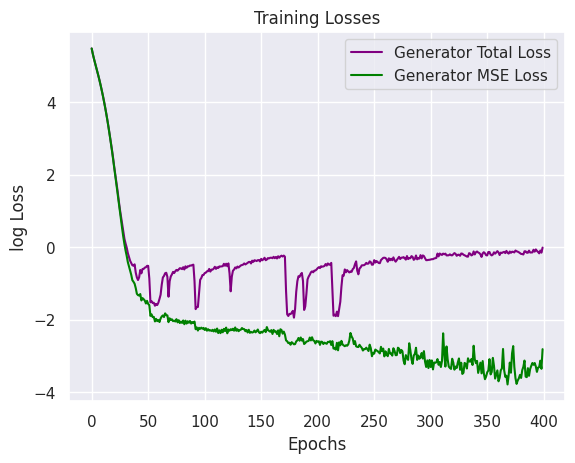

In [50]:
loss_figure = plt.figure()

axes = plt.axes()
log_g_loss = torch.log(new_dim_gLoss)
log_MSEloss = torch.log(new_dim_mseLoss)


axes.plot(log_g_loss, label='Generator Total Loss', color='purple')
axes.plot(log_MSEloss,label='Generator MSE Loss', color='green')

plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('log Loss')
plt.legend()
plt.grid(True)
plt.show()

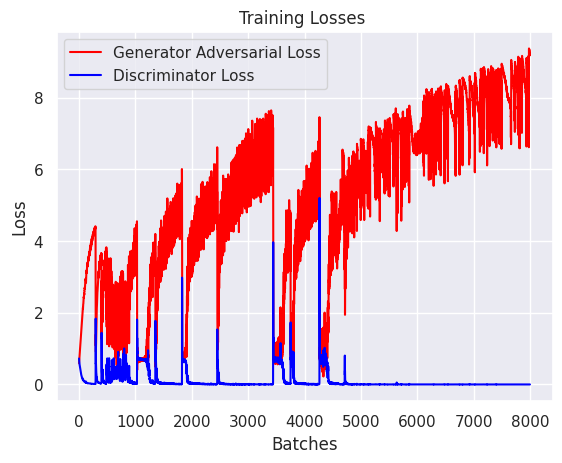

In [51]:
loss_figure = plt.figure()

axes = plt.axes()
axes.plot(g_ADVloss_tensor, label='Generator Adversarial Loss', color='red')
axes.plot(d_loss_tensor,label='Discriminator Loss', color='blue')
plt.title('Training Losses ')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

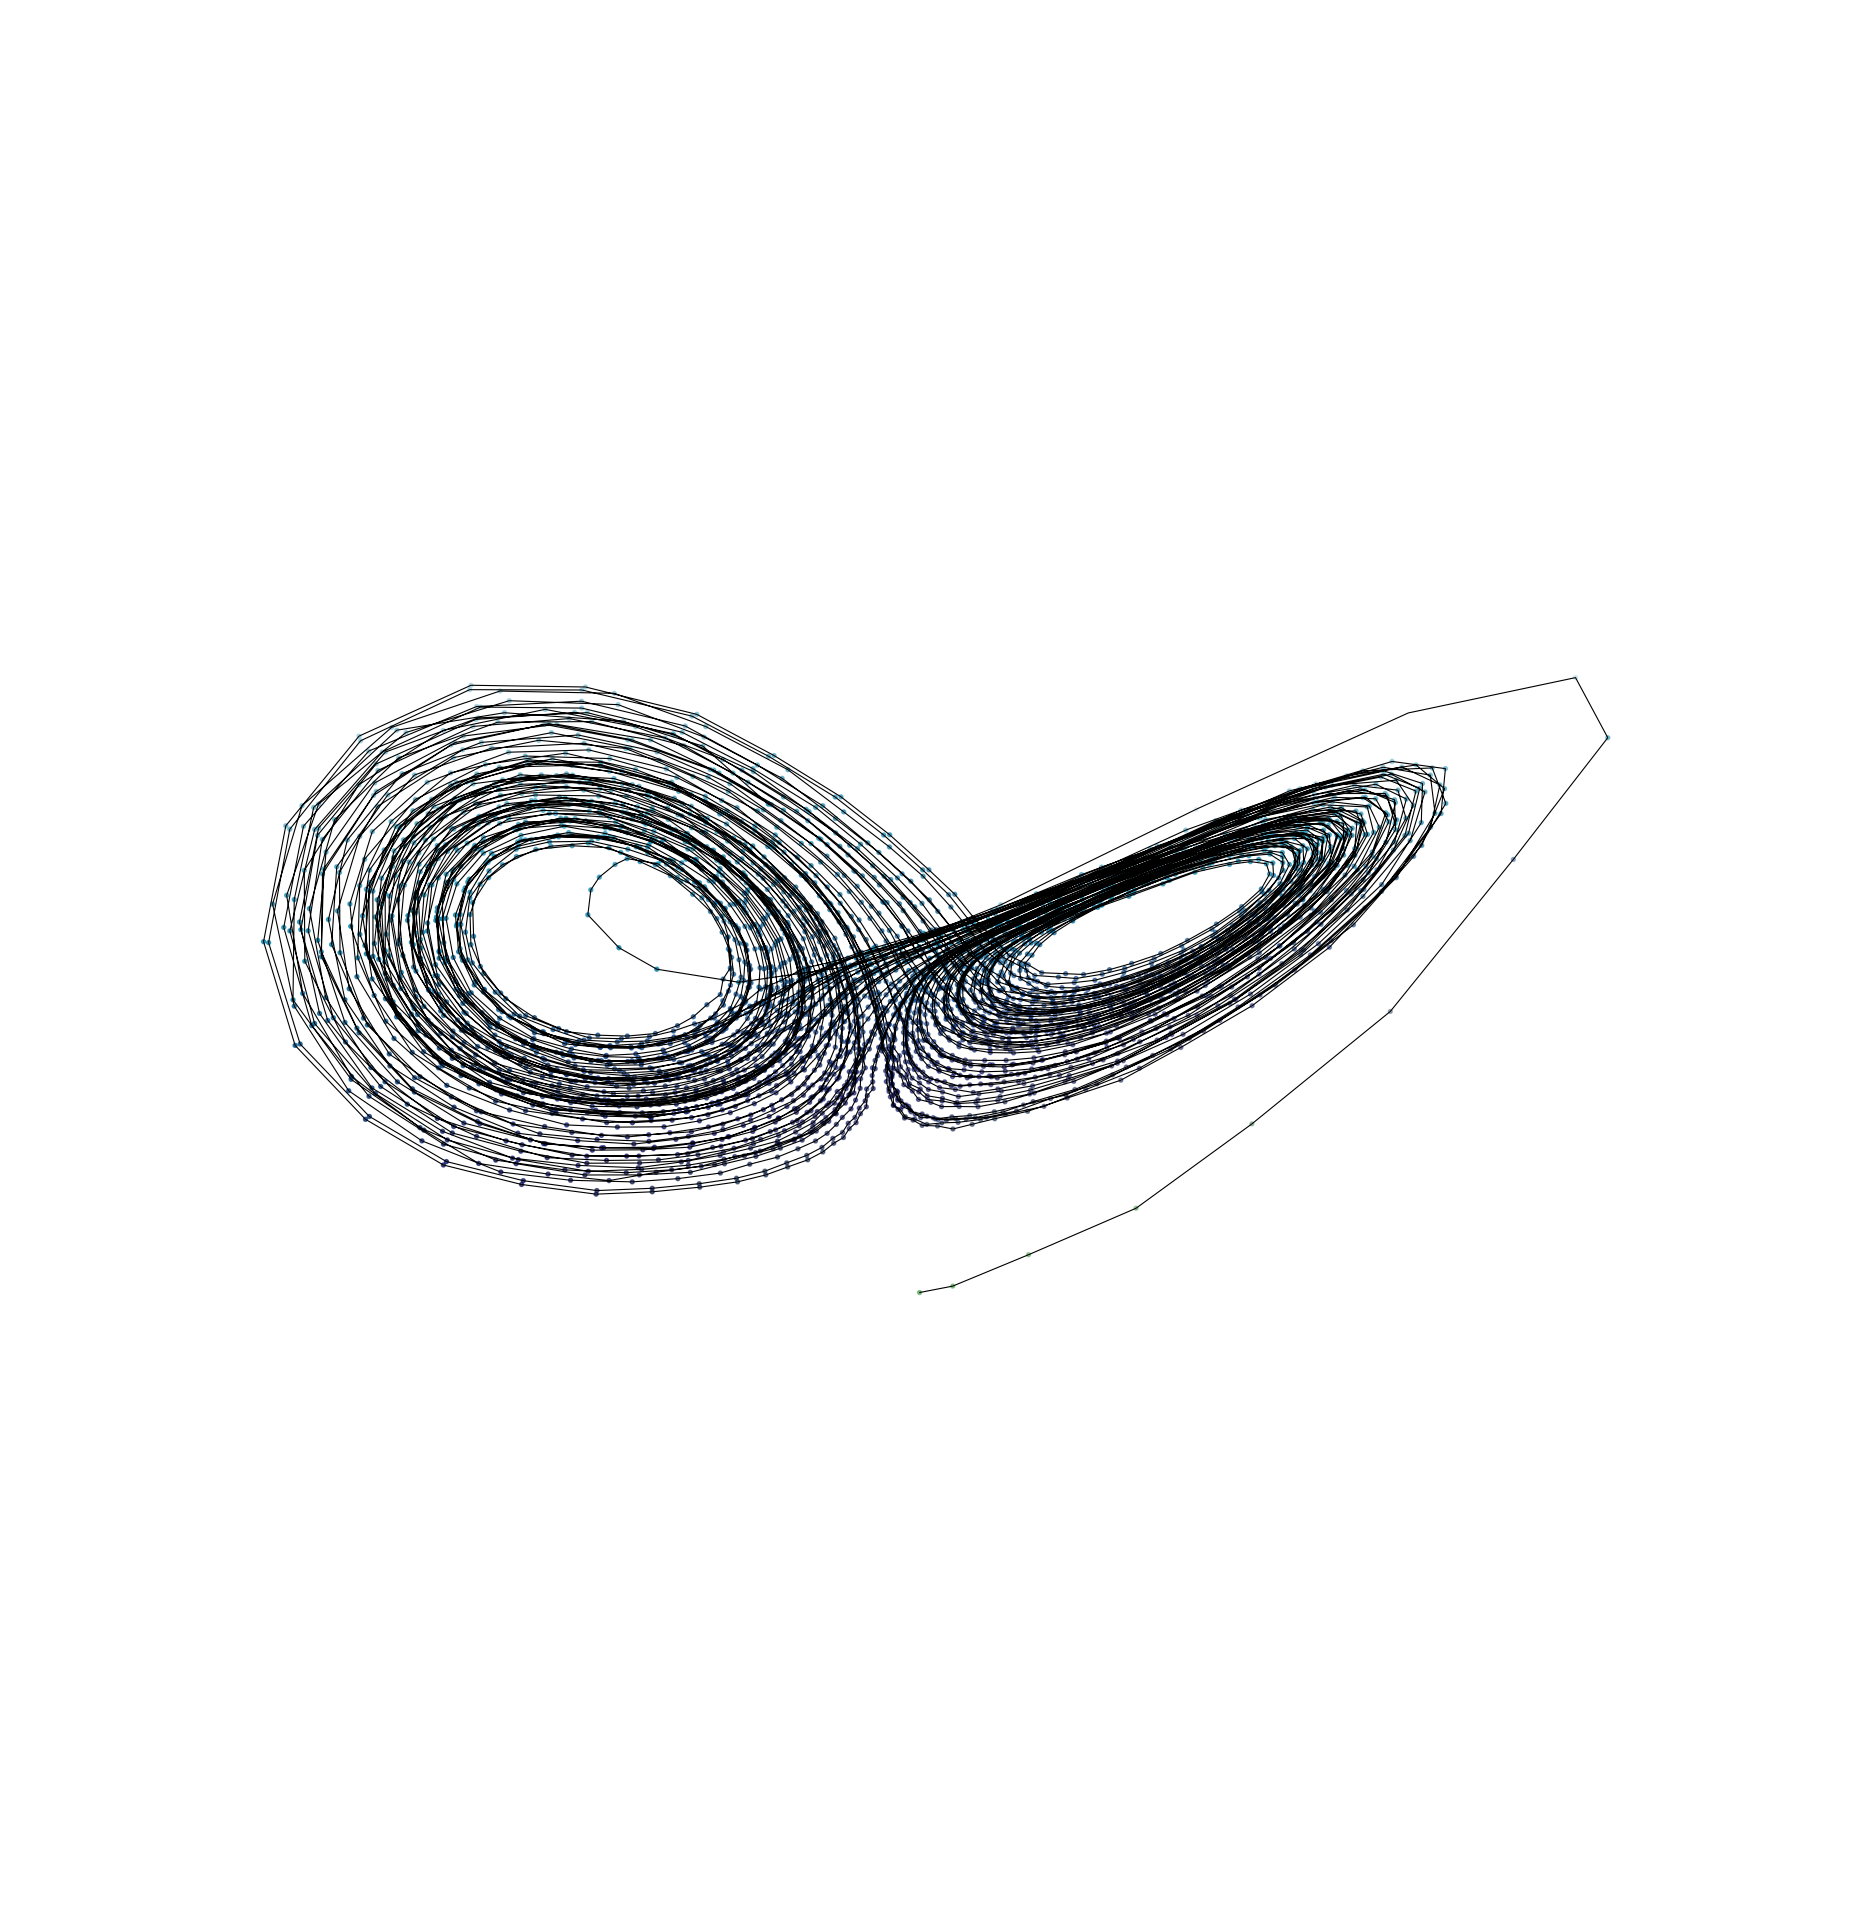

In [57]:
#plot for a sample super-resolution trajectory

sample_test_lr = test_dataset[10]['lr'].unsqueeze(0)
with torch.no_grad():
    generated_data = generator(sample_test_lr.to(device))

generated_data_np = generated_data.detach().cpu().numpy()
#print(generated_data_np)
x_sr = generated_data_np[0,0,:]
y_sr = generated_data_np[0,1,:]
z_sr = generated_data_np[0,2,:]

a = 5
fig = plt.figure(facecolor='w', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('w')
axes.plot(x_sr,y_sr,z_sr,'black', linewidth=0.8)
axes.scatter3D(x_sr, y_sr, z_sr, c=z_sr, cmap='ocean', s = 8)

plt.grid(False)
plt.axis('off')
plt.title('Lorenz generated',color='white', fontsize=10*a)
plt.show()

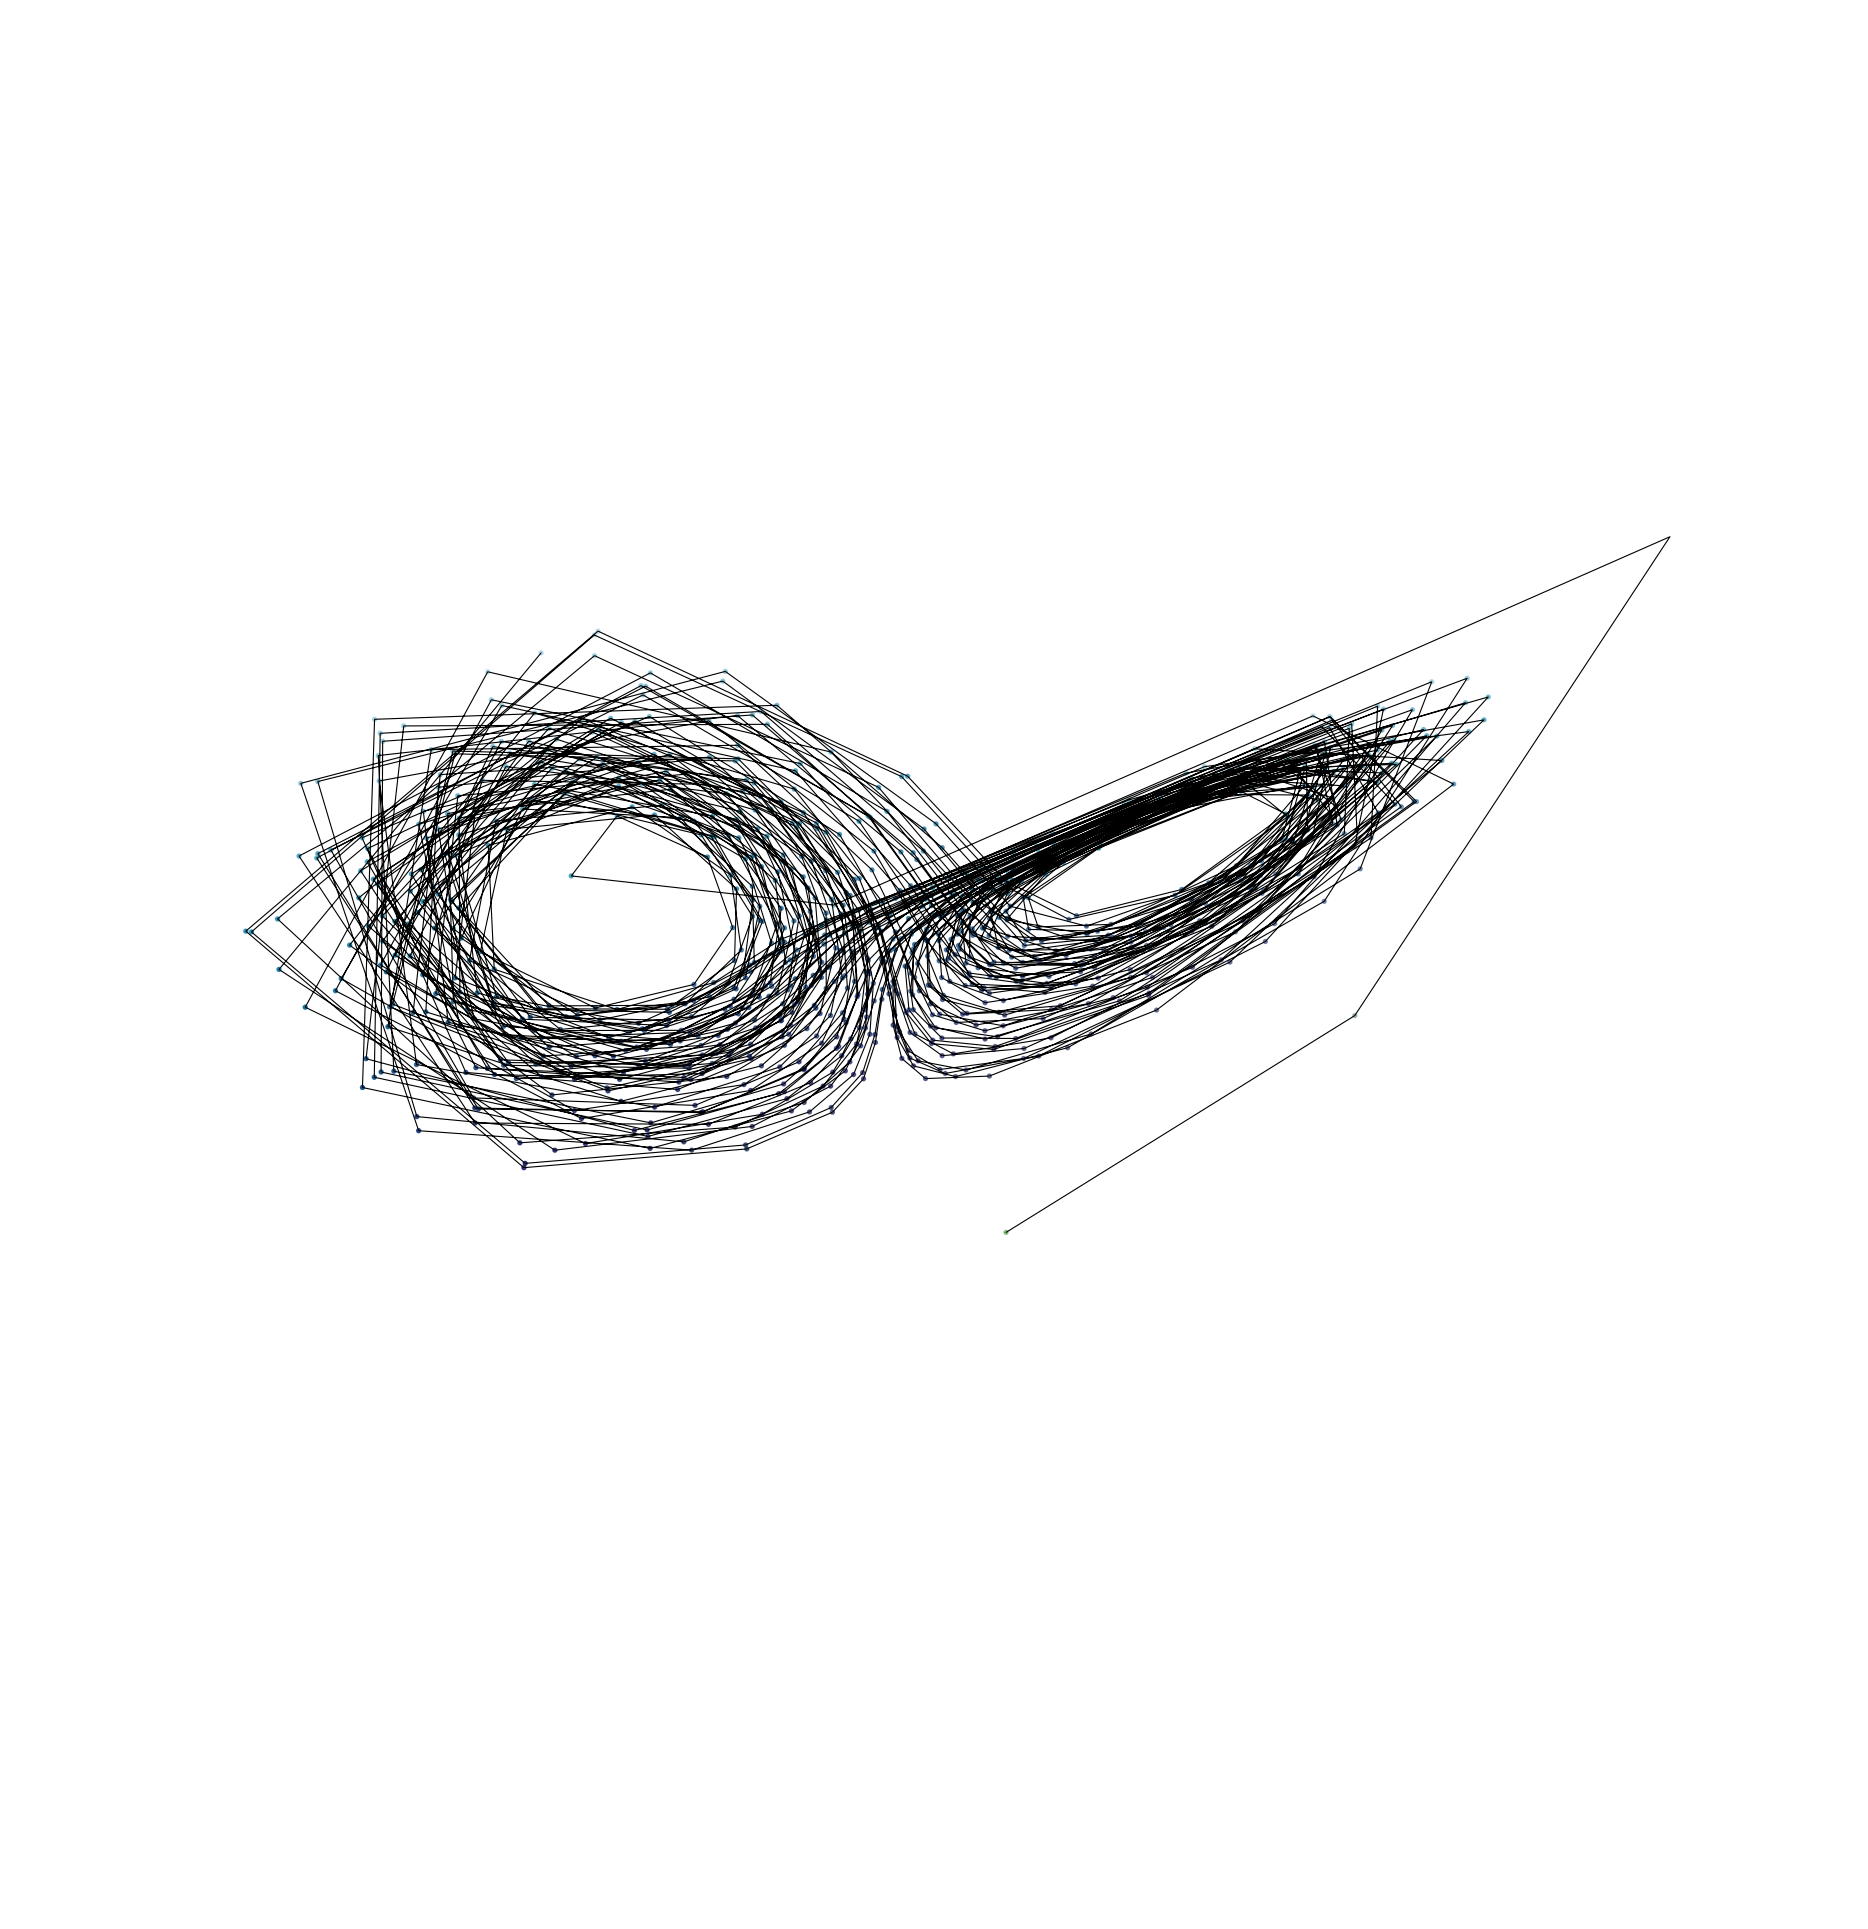

In [58]:
#plot for a sample low-resolution trajectory
sample_test_lr = test_dataset[10]['lr']
#print(sample_test_lr)
sample_test_lr_np = sample_test_lr.detach().cpu().numpy()
x_lr = sample_test_lr_np[0,:]
y_lr = sample_test_lr_np[1,:]
z_lr = sample_test_lr_np[2,:]

a = 5
fig = plt.figure(facecolor='w', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('w')
axes.plot(x_lr,y_lr,z_lr,'black', linewidth=0.8)
axes.scatter3D(x_lr, y_lr, z_lr, c=z_lr, cmap='ocean', s = 8)

plt.grid(False)
plt.axis('off')
plt.title('Lorenz low resolution',color='white', fontsize=10*a)
plt.show()

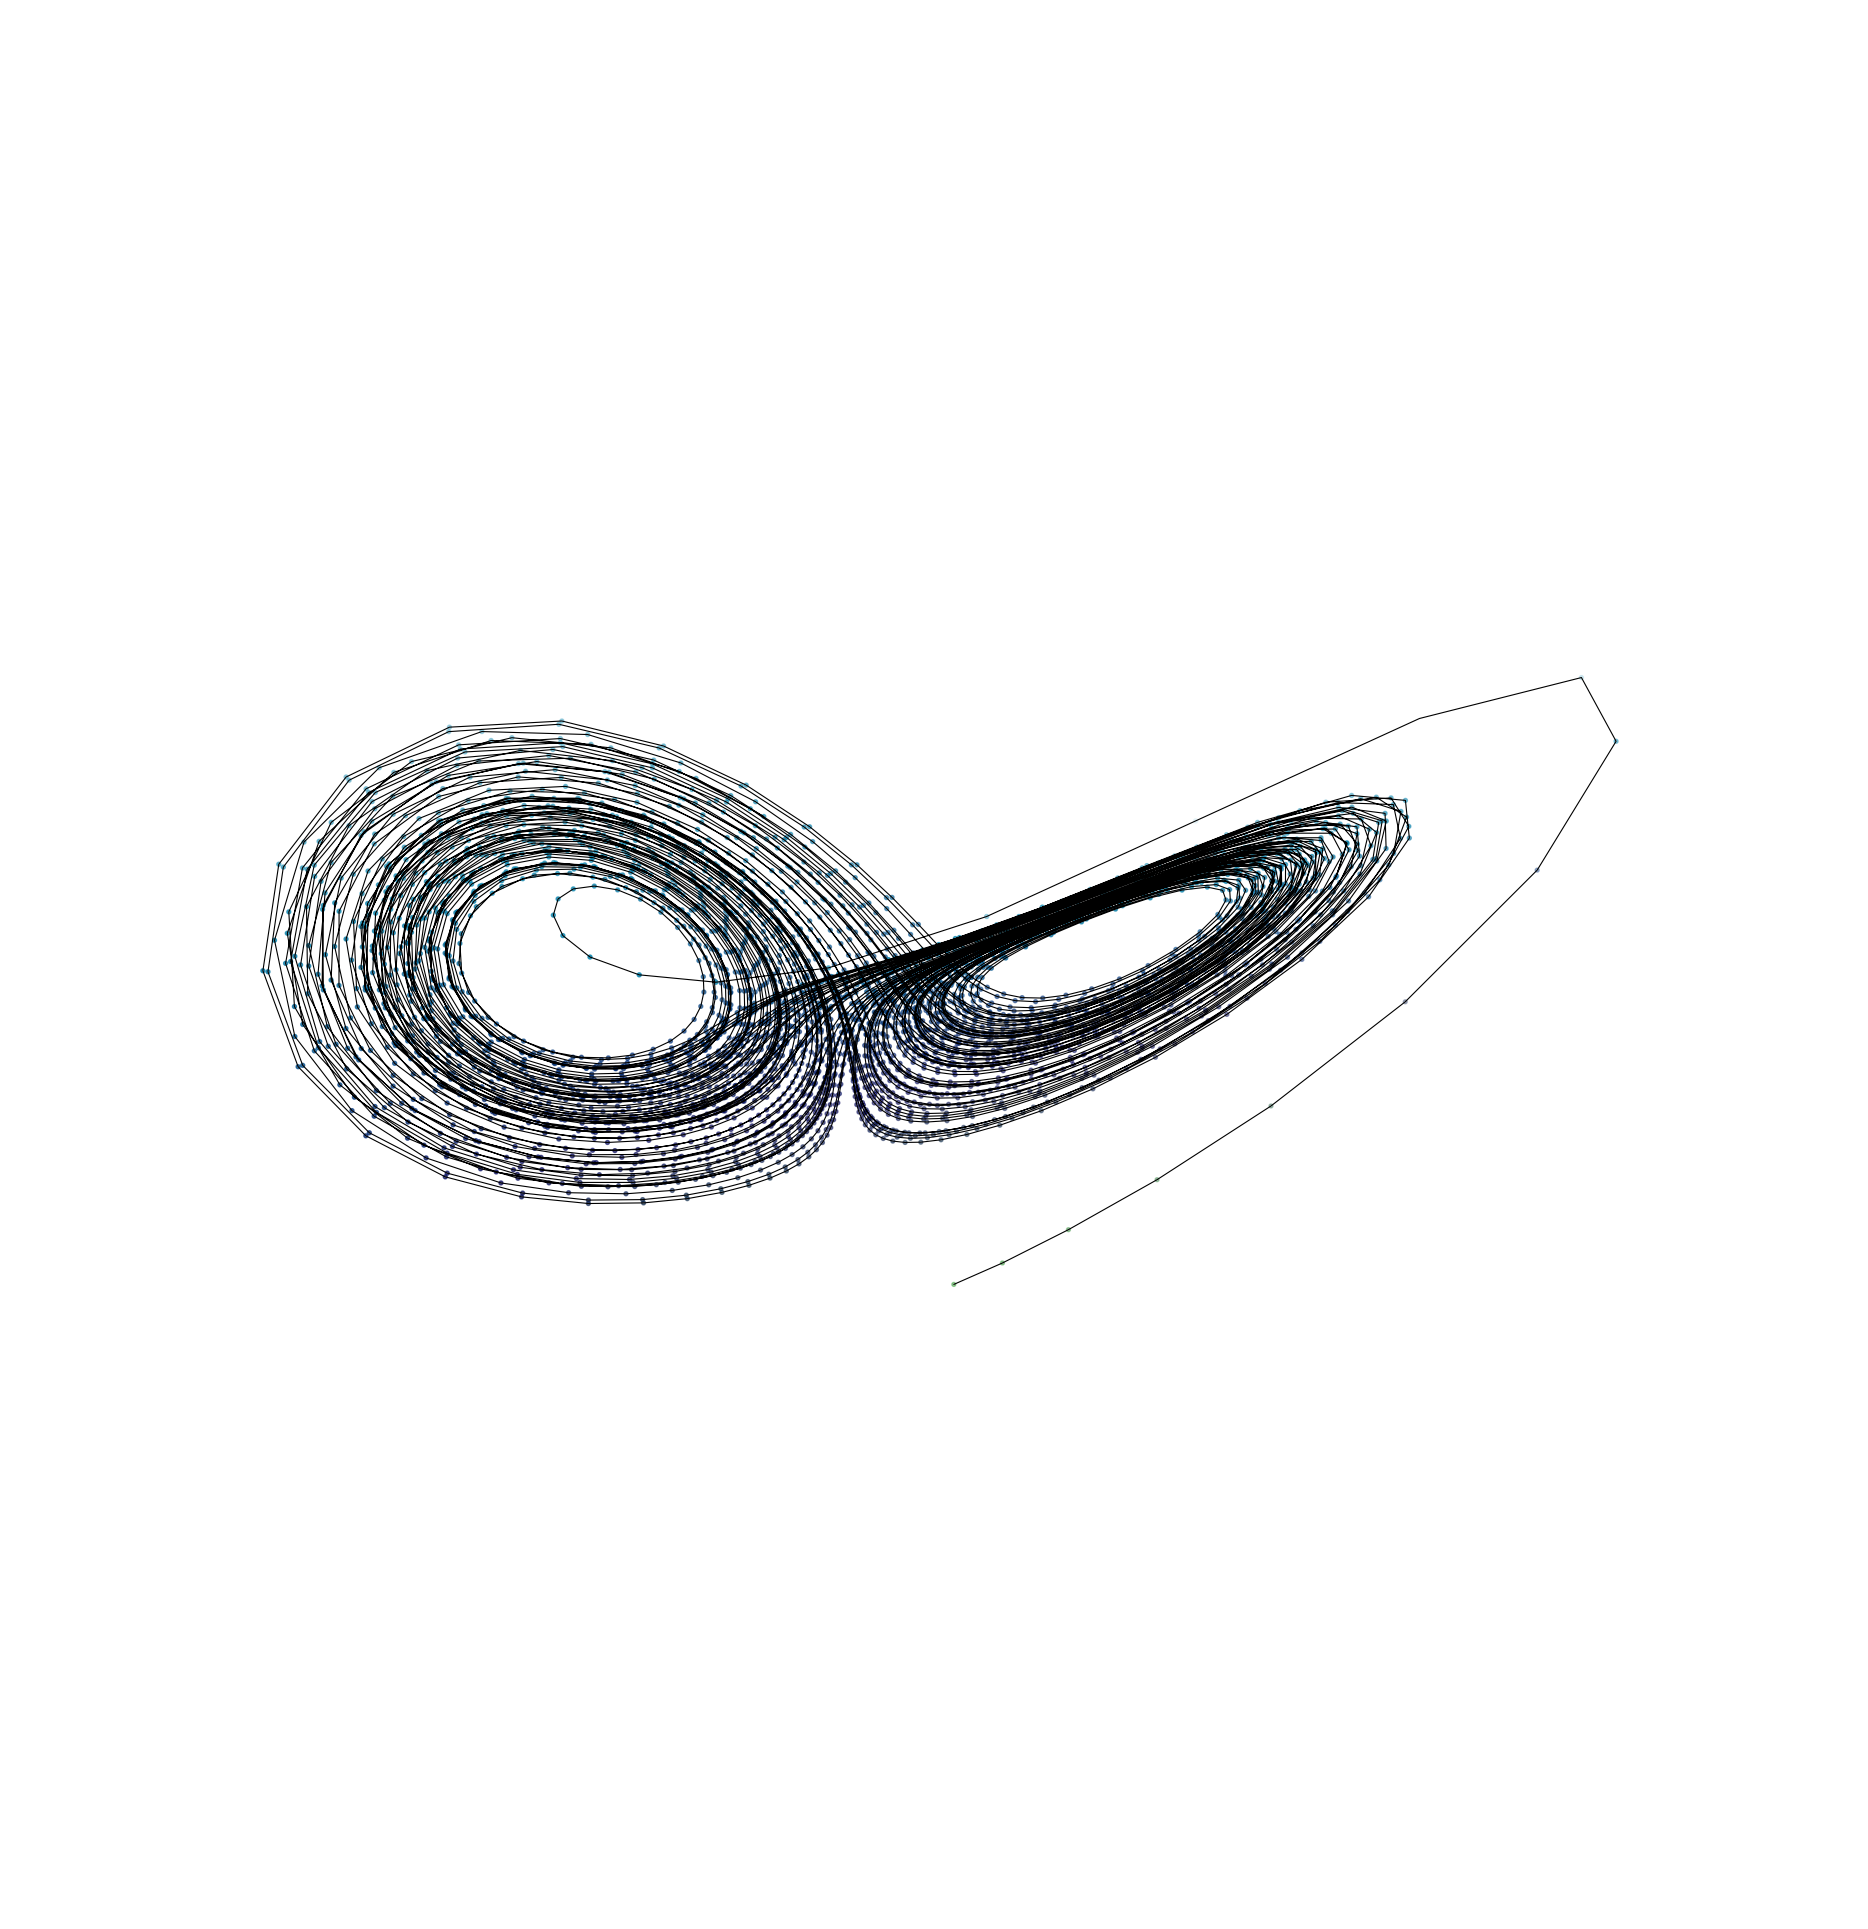

In [59]:
#plot for a sample high-resolution trajectory
sample_test_hr = test_dataset[10]['hr']
#print(sample_test_lr)
sample_test_hr_np = sample_test_hr.detach().cpu().numpy()
x_hr = sample_test_hr_np[0,:]
y_hr = sample_test_hr_np[1,:]
z_hr = sample_test_hr_np[2,:]

a = 5
fig = plt.figure(facecolor='w', figsize=(6.4*a, 4.8*a)) #creates figure

axes = plt.axes(projection="3d") # 3d plot area for 3d data
axes.set_facecolor('w')
axes.plot(x_hr,y_hr,z_hr,'black', linewidth=0.8)
axes.scatter3D(x_hr, y_hr, z_hr, c=z_hr, cmap='ocean', s = 8)

plt.grid(False)
plt.axis('off')
plt.title('Lorenz high resolution',color='white', fontsize=10*a)
plt.show()

/tmp/ipykernel_34/1226712826.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hr_test_tensor = torch.tensor(hr_test,dtype=torch.float32)
/tmp/ipykernel_34/1226712826.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lr_test_tensor = torch.tensor(lr_test,dtype=torch.float32)


Average MSE sr,hr: 0.09028332484886051
 relative sr: 0.0034648848885295526
abs difference sr:  0.2246221613138914


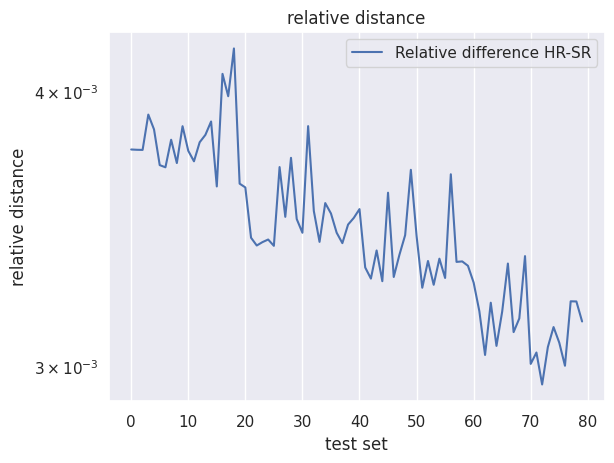

In [55]:
''' Calculation of MSE and relative distance
For temporal upscaling the calulations between the low resolution and high resolution data needs to be commented out
because they have a different amount of timesteps'''
mse_values = []
mse_values_lr_hr = []
relative_difference_values = []
relative_difference_values2 = []
abs_diff_values = []
abs_diff_values2 = []
for batch in test_loader:
    lr_test = batch['lr']  # Low resolution  data
    hr_test = batch['hr']  # Corresponding high resolution data
    
    hr_test_tensor = torch.tensor(hr_test,dtype=torch.float32)
    lr_test_tensor = torch.tensor(lr_test,dtype=torch.float32)
    # Generate sr
    with torch.no_grad():
        sr_test = generator(lr_test.to(device))



    sr_test_tensor = sr_test.detach().cpu()    # print(len(test_dataset))
    # print(sr_test_tensor.shape)

    # Calculates MSE for each pair of SR and HR in  batch
    for sr, hr in zip(sr_test_tensor, hr_test_tensor):
        #print(hr.shape)
        mse = loss_function_mse(sr, hr)
        mse_values.append(mse.item())
    '''
    # Calculates MSE for each pair of LR and HR in  batch
    for lr, hr in zip(lr_test_tensor, hr_test_tensor):
        #print(hr.shape)
        mse2 = loss_function_mse(lr,hr)
        mse_values_lr_hr.append(mse2.item())
    '''

    max_value = torch.max(hr_test_tensor).item()
    # Calculates relative distance for each pair of SR and HR in  batch
    for sr, hr in zip(sr_test_tensor, hr_test_tensor):
          #print(hr.shape)
          abs_diff = loss_L1(sr, hr)
          abs_diff_values.append(abs_diff.item())
          relative_difference = abs_diff.item() / max_value
          relative_difference_values.append(relative_difference)
    '''
    # Calculates relative distance for each pair of LR and HR in  batch
    for lr, hr in zip(lr_test_tensor, hr_test_tensor):
        #print(hr.shape)
        abs_diff2 = loss_L1(lr, hr)
        abs_diff_values2.append(abs_diff2.item())
        relative_difference2 = abs_diff2.item() / max_value
        relative_difference_values2.append(relative_difference2)
    '''
        
#print(mse_values)

mse_average = sum(mse_values) / len(mse_values)
#mse2_average = sum(mse_values_lr_hr) / len(mse_values_lr_hr)
abs_diff_avg_sr = sum(abs_diff_values) / len(abs_diff_values)
#abs_diff_avg_lr = sum(abs_diff_values2) / len(abs_diff_values2)
print(f"Average MSE sr,hr: {mse_average}")
#print(f"Average MSE lr,hr: {mse2_average}")
diff_average_sr = sum(relative_difference_values) / len(relative_difference_values)
#diff_average_lr = sum(relative_difference_values2) / len(relative_difference_values2)
print(" relative sr:", diff_average_sr)
#print("relative lr:", diff_average_lr)
print("abs difference sr: ", abs_diff_avg_sr)
#print("abs difference lr: ", abs_diff_avg_lr)



plt.title("relative distance")
plt.xlabel("test set")
plt.ylabel("relative distance")
plt.yscale("log")
#plt.plot(mse_values, label="hr-sr")
#plt.plot(mse_values_lr_hr, label="hr-lr")
plt.plot(relative_difference_values, label ="Relative difference HR-SR")
#plt.plot(relative_difference_values2, label = "Relative difference HR-LR")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (800,) and (1000,)

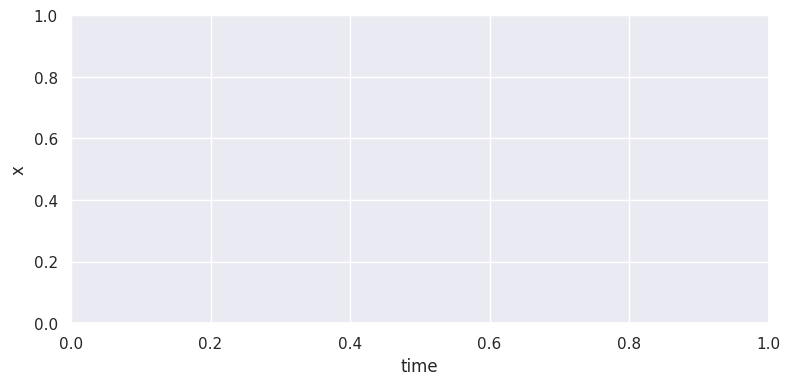

In [56]:
#1D representation
plt.figure(figsize=(9, 4))

plt.xlabel("time")
plt.ylabel("x")

time = np.linspace(0, 7, 800)
plt.plot(time,x_lr,  'cyan', label='Low Resolution')
plt.plot(time,x_hr, 'magenta', label='High Resolution')
plt.plot(time,x_sr, 'green', label='Super Resolution')
plt.legend()
#plt.gca().set_facecolor('white')
plt.show()



In [ ]:
plt.figure(figsize=(9, 4))

plt.xlabel("time")
plt.ylabel("y")


plt.plot(time,y_lr, 'cyan', label='Low Resolution')
plt.plot(time,y_hr, 'magenta', label='High Resolution')
plt.plot(time,y_sr, 'green', label='Super Resolution')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9, 4))

plt.xlabel("time")
plt.ylabel("z")


plt.plot(time,z_lr, 'cyan', label='Low Resolution')
plt.plot(time,z_hr, 'magenta', label='High Resolution')
plt.plot(time,z_sr, 'green', label='Super Resolution')
plt.legend()
plt.show()

In [ ]:
def my_lorenz_system(t,vec,sigma,p,beta):
  x,y,z = vec
  dxdt = sigma*(y-x)
  dydt = x*(p-z)-y
  dzdt = x*y-beta*z
  return dxdt,dydt,dzdt

#initial conditions


x0 = 2
y0 = 3
z0 = -14


#x0,y0,z0 = 0.9927168, 0.9545199, 0.8107614

x00 = x0 #+ 1e-9
y00 = y0 +0.001 #+ 1e-9
z00 = z0 #+ 1e-9
#x0, y0, z0 = np.random.normal(loc=1, scale=10, size=3)
print(x0, y0, z0)
#parameters
sigma = 10
beta = 8/3
p = 28

t_span = (0,16)

t_eval = np.linspace(t_span[0], t_span[1], 800) #array of time points for solution

#high resolution trajectories
sol_hr = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta),atol=1e-4, rtol=1e-4)
sol_hr2 = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x00,y00,z00], t_eval = t_eval, args = (sigma,p,beta),atol=1e-4, rtol=1e-4)

#low resolution trajectories
sol_lr = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x0,y0,z0], t_eval = t_eval, args = (sigma,p,beta),atol=1e-2, rtol=1e-2)
sol_lr2 = solve_ivp(my_lorenz_system, t_span = t_span, y0 = [x00,y00,z00], t_eval = t_eval, args = (sigma,p,beta),atol=1e-2, rtol=1e-2)

with torch.no_grad():
    sol_lr_tensor = torch.tensor(sol_lr.y, dtype=torch.float32).unsqueeze(0).to(device)  
    sol_lr2_tensor = torch.tensor(sol_lr2.y, dtype=torch.float32).unsqueeze(0).to(device) 

    # Generate hr solutions
    sol_sr = generator(sol_lr_tensor)
    sol_sr2 = generator(sol_lr2_tensor)

sol_sr_np = sol_sr.detach().cpu().numpy()
sol_sr2_np = sol_sr2.detach().cpu().numpy()

print(sol_sr.shape)
solution = sol_hr.y
print(solution.shape)
x1 = solution[0,:]
y1 = solution[1,:]
z1 = solution[2,:]

solution2 = sol_hr2.y
x2 = solution2[0,:]
y2 = solution2[1,:]
z2 = solution2[2,:]

solution3 = sol_lr.y
x3 = solution3[0,:]
y3 = solution3[1,:]
z3 = solution3[2,:]

solution4 = sol_lr2.y
x4 = solution4[0,:]
y4 = solution4[1,:]
z4 = solution4[2,:]

solution_sr = sol_sr_np
print(solution_sr.shape)
x5 = solution_sr[0,0,:]
y5 = solution_sr[0,1,:]
z5 = solution_sr[0,2,:]

solution_sr2 = sol_sr2_np
x6 = solution_sr2[0,0,:]
y6 = solution_sr2[0,1,:]
z6 = solution_sr2[0,2,:]
print(solution_sr2.shape)

init_distance =np.sqrt((x2[0]-x1[0])**2+(y2[0]-y1[0])**2+(z2[0]-z1[0])**2)
print(init_distance)
distance_hr = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
distance_lr = np.sqrt((x3-x4)**2+(y3-y4)**2+(z3-z4)**2)
distance_sr = np.sqrt((x5-x6)**2+(y5-y6)**2+(z5-z6)**2)
init_distance_sr = np.sqrt((x6[0]-x5[0])**2+(y6[0]-y5[0])**2+(z6[0]-z5[0])**2)
print("distance between initial points sr trajectories: ",init_distance_sr)
average_distance = sum(distance_sr) / len(distance_sr)
print("average difference", average_distance)
distance_hr[distance_hr == 0] = 1e-10
distance_lr[distance_lr == 0] = 1e-10
distance_sr[distance_sr == 0] = 1e-10

time = t_eval

lyapunov = init_distance * np.exp(0.9056 * time)

plt.figure()
plt.yscale("log")
plt.plot(time,distance_sr, label="Distance SR")
plt.plot(time,distance_hr, label="Distance HR")
plt.plot(time,distance_lr, label="Distance LR")
plt.plot(time,lyapunov, label="Lyaponov exponent")
plt.xlabel("time")
plt.ylabel("absolute distance")
plt.legend()
plt.show()